In [33]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

%matplotlib inline

In [34]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -f data
!ln -s '/content/drive/My Drive/proj2_data' data

#some utility

In [35]:
def collate_fn1(batch):
    return tuple(zip(*batch))

def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type=='turbulence':
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

# define dataset

In [36]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])

    def __getitem__(self, index):
      path, box, turb = self.imgs[index]
      im = (np.load(path))/292*255
      im=np.transpose(im,(1, 2, 0))
      im=np.uint8(im)
      boxes = np.array(box, dtype='float32')
      seed = np.random.randint(2147483647)
      random.seed(seed)
      torch.manual_seed(seed)
      PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
      im = self.transform(PIL)*255


      #return im,target
      return im, boxes, turb

    def __len__(self):
        return len(self.imgs)

In [37]:
#dataloader
train=MyDataset(datatype='train', transform=None)
test=MyDataset(datatype='test', transform=None)
val=MyDataset(datatype='val', transform=None)
datasets={'train':train,'test':test,'val':val}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2,collate_fn=collate_fn1,pin_memory=True) for k, v in datasets.items()}

#test

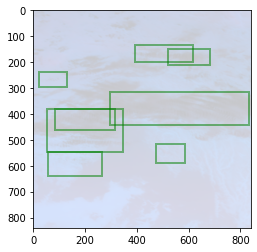

In [38]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]

inp = im.numpy().transpose((1, 2, 0))/255
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
#inp = std * inp + mean
imshow(inp, box,turb)

In [39]:
idx=0
for i in enumerate(dataloaders['train']):
  print(i)
  idx=idx+1
  if idx==3:break

(0, ((tensor([[[191., 191., 191.,  ..., 191., 191., 191.],
         [191., 191., 191.,  ..., 191., 192., 192.],
         [191., 191., 191.,  ..., 191., 191., 192.],
         ...,
         [208., 208., 208.,  ..., 206., 206., 206.],
         [208., 208., 208.,  ..., 207., 207., 207.],
         [208., 208., 208.,  ..., 207., 207., 207.]],

        [[197., 197., 197.,  ..., 197., 197., 197.],
         [197., 197., 197.,  ..., 197., 197., 197.],
         [197., 197., 197.,  ..., 197., 197., 197.],
         ...,
         [223., 223., 226.,  ..., 212., 212., 212.],
         [225., 225., 225.,  ..., 212., 212., 212.],
         [225., 225., 225.,  ..., 214., 212., 212.]],

        [[195., 195., 195.,  ..., 193., 193., 193.],
         [193., 195., 195.,  ..., 193., 194., 194.],
         [193., 193., 194.,  ..., 193., 193., 194.],
         ...,
         [247., 247., 254.,  ..., 223., 223., 223.],
         [252., 252., 252.,  ..., 222., 222., 222.],
         [252., 252., 252.,  ..., 226., 222., 2